# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in `pierce_county_house_sales.csv`, car prices in `cars_hw.csv`, and airbnb rental prices in `airbnb_hw.csv`.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an 80/20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. Use the `sklearn.linear_model.Lasso` to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

[info] target column → Price

 Basic describe() (numerics)
                              count          mean           std     min        25%        50%         75%         max
Price                       30461.0  1.636450e+02  1.978230e+02    10.0       81.0      125.0       195.0     10000.0
Host Id                     30461.0  1.272556e+07  1.189930e+07   500.0  2699261.0  8541842.0  21191082.0  43033067.0
Review Scores Rating (bin)  30461.0  9.053700e+01  7.733000e+00    20.0       90.0       90.0        95.0       100.0
Zipcode                     30461.0  1.058238e+04  9.200350e+02  1003.0    10017.0    10065.0     11216.0     99135.0
Beds                        30461.0  1.529000e+00  1.014000e+00     0.0        1.0        1.0         2.0        16.0
Number of Records           30461.0  1.000000e+00  0.000000e+00     1.0        1.0        1.0         1.0         1.0
Number Of Reviews           30461.0  1.202500e+01  2.198500e+01     0.0        0.0        3.0        13.0       257

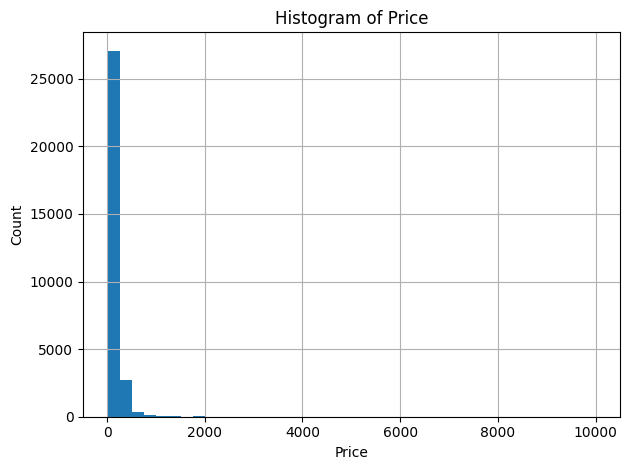

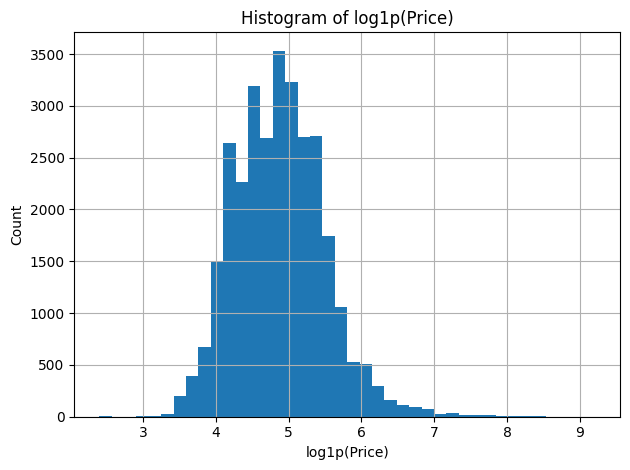


[info] numeric features: ['Host Id', 'Review Scores Rating (bin)', 'Zipcode', 'Beds', 'Number of Records', 'Number Of Reviews', 'Review Scores Rating']
[info] categorical (OHE) features: ['Neighbourhood ', 'Property Type', 'Room Type']


/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



 Linear models (train/test)
                                                                                        model  r2_train  r2_test  rmse_train_log  rmse_test_log  ~pct_err_test
                                                                            Model A: ['Beds']    0.1610   0.1541          0.5692         0.5762        77.9245
Model B: ['Beds', 'Zipcode', 'Host Id', 'Review Scores Rating', 'Review Scores Rating (bin)']    0.2337   0.2542          0.5440         0.5410        71.7737
                                                               Model C: nums + small OHE cats    0.5590   0.5725          0.4126         0.4096        50.6194


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

CSV_PATH = Path("./data/airbnb_hw.csv") # can change to any of the three datasets
RANDOM_STATE = 42
TEST_SIZE = 0.20
SAMPLE_N = None
MAX_NUM_COLS = 20
MAX_CAT_LEVELS = 30
MAX_CAT_COLS = 8

def detect_target(df: pd.DataFrame) -> str:
    for c in df.columns:
        if any(k in c.lower() for k in ["price", "msrp"]):
            return c
    return df.columns[-1]

def coerce_price(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        return s
    s2 = s.astype(str).str.replace(r"[\$,]", "", regex=True).str.replace(r"\s+", "", regex=True)
    return pd.to_numeric(s2, errors="coerce")

def rmse(y_true, y_pred) -> float:
    return np.sqrt(mean_squared_error(y_true, y_pred))

def approx_pct_err_from_log_rmse(rmse_log: float) -> float:
    return (np.exp(rmse_log) - 1.0) * 100.0

def eval_lr(name, Xtr, Xte, ytr, yte):
    lr = LinearRegression()
    lr.fit(Xtr, ytr)
    p_tr = lr.predict(Xtr); p_te = lr.predict(Xte)
    out = {
        "model": name,
        "r2_train": r2_score(ytr, p_tr),
        "r2_test":  r2_score(yte, p_te),
        "rmse_train_log": rmse(ytr, p_tr),
        "rmse_test_log":  rmse(yte, p_te),
    }
    out["~pct_err_test"] = approx_pct_err_from_log_rmse(out["rmse_test_log"])
    return out

# 1
df_raw = pd.read_csv(CSV_PATH)
df = df_raw.sample(SAMPLE_N, random_state=RANDOM_STATE).copy() if SAMPLE_N and df_raw.shape[0] > SAMPLE_N else df_raw.copy()

target = detect_target(df)
print(f"[info] target column → {target}")

df[target] = coerce_price(df[target])
df = df.drop_duplicates()
df = df[~df[target].isna()].copy()

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target in num_cols: num_cols.remove(target)
cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()

for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

print("\n Basic describe() (numerics)")
print(df[[target]+num_cols].describe().transpose().round(3).to_string())

plt.figure()
df[target].hist(bins=40)
plt.title(f"Histogram of {target}"); plt.xlabel(target); plt.ylabel("Count")
plt.tight_layout(); plt.show()

df["log_price"] = np.log1p(df[target])
plt.figure()
df["log_price"].hist(bins=40)
plt.title(f"Histogram of log1p({target})"); plt.xlabel(f"log1p({target})"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# 2
small_cats = [c for c in cat_cols if df[c].nunique() <= MAX_CAT_LEVELS][:MAX_CAT_COLS]
num_cols = num_cols[:MAX_NUM_COLS]

print("\n[info] numeric features:", num_cols)
print("[info] categorical (OHE) features:", small_cats)

# 3
idx_train, idx_test = train_test_split(df.index, test_size=TEST_SIZE, random_state=RANDOM_STATE)

y = df["log_price"]

# 4
results = []

if len(num_cols) > 0:
    corrs_all = df[num_cols].corrwith(y).abs().sort_values(ascending=False)
    best_num = [corrs_all.index[0]]
    XA = df[best_num]
else:
    best_num = []
    XA = pd.DataFrame(index=df.index)

Xtr_A, Xte_A = XA.loc[idx_train], XA.loc[idx_test]
ytr, yte = y.loc[idx_train], y.loc[idx_test]
results.append(eval_lr(f"Model A: {best_num}", Xtr_A, Xte_A, ytr, yte))

few_nums = corrs_all.head(min(5, len(num_cols))).index.tolist() if len(num_cols)>0 else []
XB = df[few_nums] if few_nums else pd.DataFrame(index=df.index)
Xtr_B, Xte_B = XB.loc[idx_train], XB.loc[idx_test]
results.append(eval_lr(f"Model B: {few_nums}", Xtr_B, Xte_B, ytr, yte))

XC = pd.concat([df[num_cols], pd.get_dummies(df[small_cats], drop_first=True)], axis=1)
Xtr_C, Xte_C = XC.loc[idx_train], XC.loc[idx_test]
results.append(eval_lr("Model C: nums + small OHE cats", Xtr_C, Xte_C, ytr, yte))

# Print metrics
print("\n Linear models (train/test)")
print(pd.DataFrame(results)[
    ["model","r2_train","r2_test","rmse_train_log","rmse_test_log","~pct_err_test"]
].round(4).to_string(index=False))


Q1. Looking at the dataset and the histograms, the dataset looks heavily skewed, with most of the data falling in the 0-1000 range.


Q4. From the three models, The best model so far is Model C, which uses both numeric and categorical variables. It acheived the highest R^2 value on the test set (0.5725) and the lowest RMSE (0.4096) on the log price. The small gap between train R^2 (0.56) and test R^2 (0.57) shows no overfitting; the model generalizes well. Models A and B clearly underfit, as they capture only a small fraction of price variation.

Rsq:  0.24375659238570535


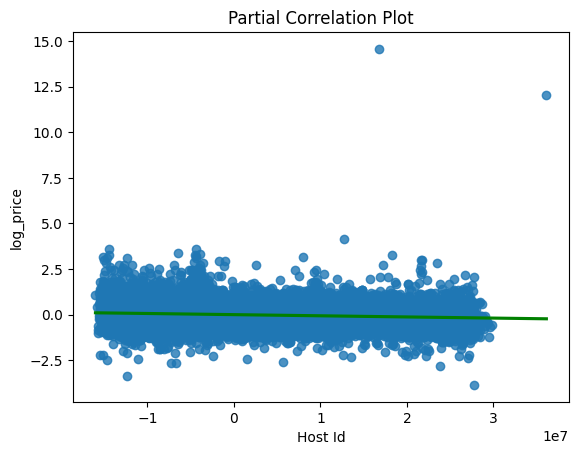

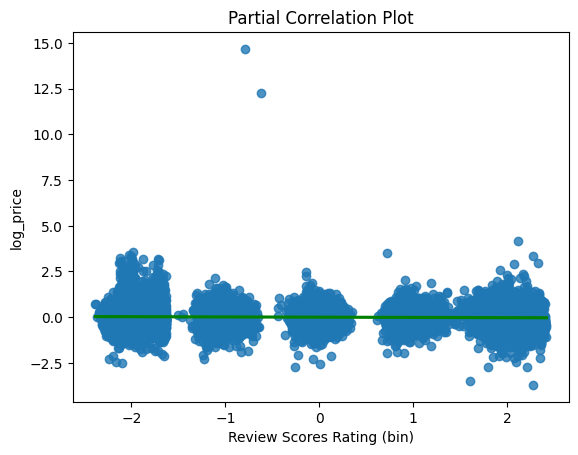

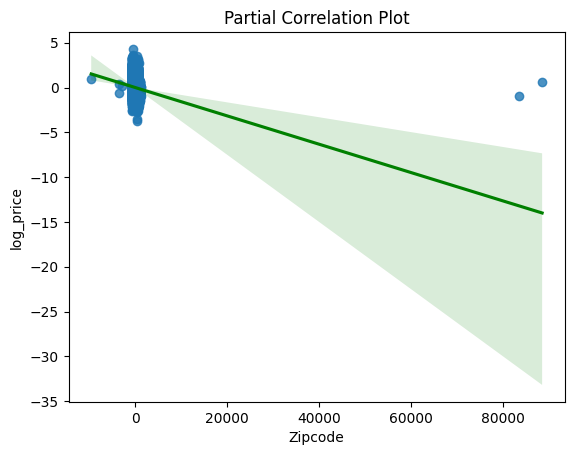

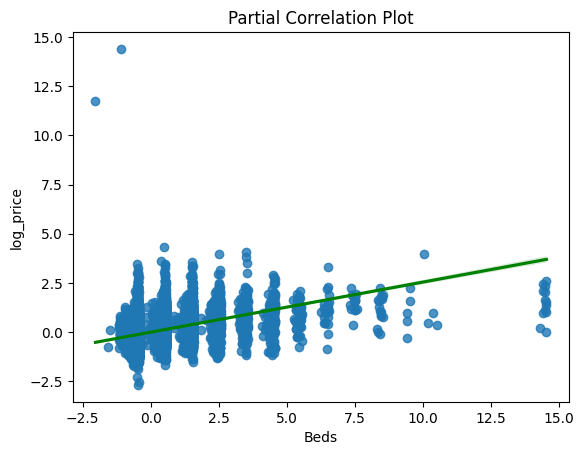

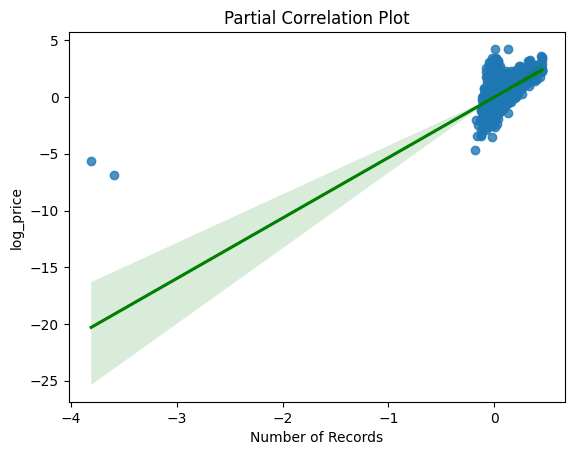

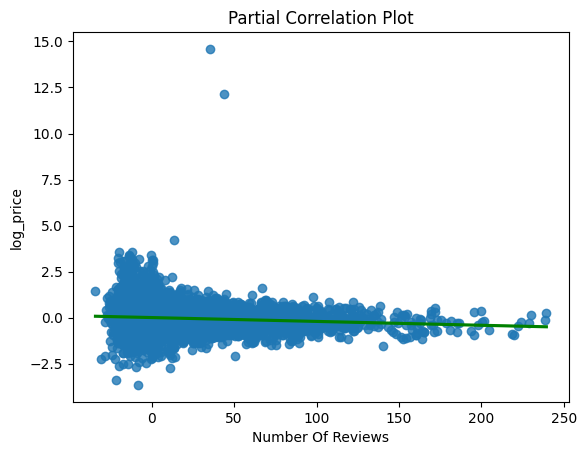

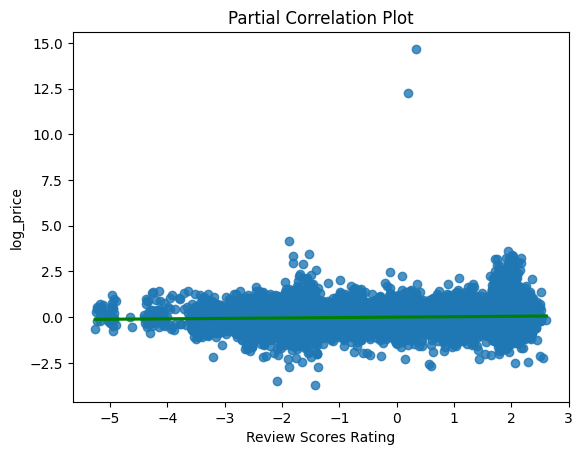

In [ ]:
# 5
import seaborn as sns
from sklearn.linear_model import LinearRegression # Import linear regression model

y = df['log_price'] # Target variable
X_n = df.loc[:,num_cols] #numeric variables
X = X_n
reg = LinearRegression(fit_intercept=True).fit(X, y) # Fit the linear model
print('Rsq: ', reg.score(X,y) )

for var in X_n:
    x_k = X[var]
    X_mk = X.drop(var,axis=1)
    ## 1. Regress y on x\k, save residual r_y
    reg_y = LinearRegression(fit_intercept=False).fit(X_mk, y) # Fit the linear model
    r_y = y - reg_y.predict(X_mk)

    ## 2. Regress x_k on x\k, save residual r_x
    reg_k = LinearRegression(fit_intercept=False).fit(X_mk, x_k) # Fit the linear model
    r_x = x_k - reg_k.predict(X_mk)

    ## 3. Plot r_y against r_k
    sns.regplot(y=r_y, x=r_x, line_kws={"color": "green"}).set(title='Partial Correlation Plot')
    plt.show()



Q5: No Significant non-linearities shown, though the Beds variable might have weak sign of parabolic trend on the higher bed counts. Also, there are quite a few variables show almost no linear association (eg. Host id which is expected since it's an identifier variable, and Review Scores Rating), and Zipcode and Number of Records are a bit unclear on the original data due to outliers make the plot zoomed out too much. 

In [7]:
# 6
def winsorize(x):
    # Convert from pd to np, if necessary:
    if type(x) == 'pandas.core.series.Series':
        x = x.to_numpy()
    # Compute IQR and 25, 75 quantiles:
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Winsorize x:
    x_winsor = np.copy(x)
    x_winsor[ x < lower_whisker ] = lower_whisker
    x_winsor[ x > upper_whisker ] = upper_whisker
    return(x_winsor)

df.loc[:, ['Zipcode','Number Of Reviews'] ] = df.loc[:,['Zipcode','Number Of Reviews']].apply(winsorize)
